In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl

In [2]:
df = pd.read_csv("datasets/creditcard.csv")

In [3]:
# Separate the data into the credit card frauds and non-frauds
fraud = df[df["Class"] == 1]
real = df[df["Class"] == 0]
print(len(fraud)/len(df))

0.001727485630620034


First we have to note that only a small fraction (<0.2%) of the total data points are frauds. This may make our model care less about detecting fraud, and will be dealt with later.

Amount Statistics for Fraudulent Cases:
 count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64 

Amount Statistics for Non-Fraud Cases:
 count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


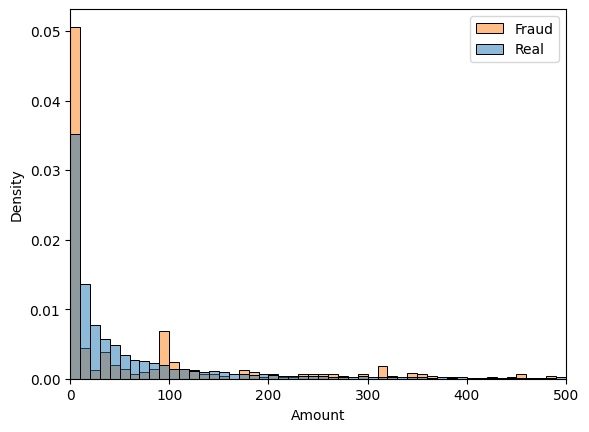

In [4]:
plt.xlim(0, 500)
sns.histplot(data=df, x="Amount", hue="Class", binwidth= 10, common_norm=False, stat="density")
plt.legend(labels=["Fraud", "Real"])
print("Amount Statistics for Fraudulent Cases:\n", fraud.Amount.describe(), "\n")
print("Amount Statistics for Non-Fraud Cases:\n", real.Amount.describe())

From the statistics we can see that on average the fraudulent claims are higher than the real claims. The graph shows that both the real and fraudulent claims follow an exponential distribution, however the real claims follow the distribution a lot closer. The fraud claims have a larger tail than the real claims (especially peaking at around 100 and 320), again meaning that fraudulent claims tend go higher than real ones.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Get data into covariate matrix and response vector
x = df.drop('Class', axis = 'columns').values
y = df.Class.values

# then into training/testing
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=4)

In [85]:
"""
ONLY USE TO RETRAIN INITIAL MODEL
"""
## Train the model:
rfc = RandomForestClassifier(random_state=4)
rfc.fit(xTrain, yTrain)

# Let's save the model as well
jl.dump(rfc, "rfcModel1.pkl")

['rfcModel1.pkl']

In [6]:
# Load the model and do predictions
rfc = jl.load("rfcModel1.pkl")

yPred = rfc.predict(xTest)

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay

## Showing some statistics
accuracy = accuracy_score(yTest, yPred)
precision = precision_score(yTest, yPred)
recall = recall_score(yTest, yPred)
f1 = f1_score(yTest, yPred)
print("Number of Claims:", yTest.shape[0], "\nPercent of Claims that are Valid:", 
      np.where(yTest==0)[0].size / yTest.size, "\nAccuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall, "\nF1 Score:", f1)


Number of Claims: 56962 
Percent of Claims that are Valid: 0.9982268881008391 
Accuracy: 0.9995435553526912 
Precision: 0.9213483146067416 
Recall: 0.8118811881188119 
F1 Score: 0.8631578947368421


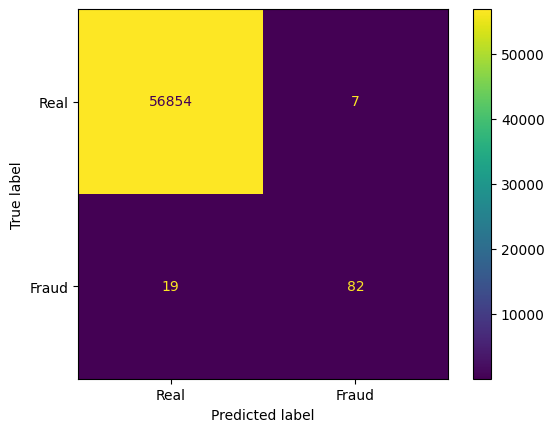

In [8]:
## Plotting a confusion matrix
cm = confusion_matrix(yTest, yPred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Real","Fraud"])
cmd.plot()

After training the random forest classifier model and using it on the test data to measure how well it performs, we find that it correctly predicts about 99.95% of the cases (accuracy). Furthermore when the model predicts fraud, it is correct in its prediction 92.13% of the time (precision). However when the claim is actually fraud, it only correctly identifies this 81.19% of the time (recall). This last statistic (recall) is the most important one for our situation, since we care most about detecting fraud with our model. Yet we could also consider the F1 score of 86.32%, which is a balance between the precision and the recall.

Since the dataset has such a small number of fraudulent claims, it is difficult for the model to get a low recall without adjusting the sampling. I will attempt to try different ratios of real:fraud cases in sampling the X and Y for the training data, and see which ones give a good recall value without lowering precision or accuracy too far. I will do this by undersampling the real cases, while maintaining every fraud case.

In [113]:
ratios = []
precision = []
recall = []
f1 = []

# "rat" is part of the ratio between fraud and real claims (fraud:real == 1:rat)
rat = 1
inc = 0.1
while (rat <= 500):
    print("trying ratio 1:", rat)
    ratios.append(rat)
    # get new X and Y from undersampled dataframe
    fraudFull = df[df["Class"] == 1]
    realSubset = df[df["Class"] == 0].sample(n=int(490*rat), random_state=4)
    dfSubset = pd.concat([fraudFull, realSubset])
    x2 = dfSubset.drop('Class', axis = 'columns').values
    y2 = dfSubset.Class.values
    xTrain2, xTest2, yTrain2, yTest2 = train_test_split(x2, y2, test_size=0.2, random_state=4)
    # train new tree
    rfc2 = RandomForestClassifier(random_state=4, n_jobs=-1)
    rfc2.fit(xTrain2, yTrain2)
    name = "rfcModel" + str(size)
    # test on existing test data
    yPred2 = rfc2.predict(xTest)
    precision.append(precision_score(yTest, yPred2))
    recall.append(recall_score(yTest, yPred2))
    f1.append(f1_score(yTest, yPred2))
    rat = round(rat + inc, 2)
    if (rat%(inc * 100) == 0):
        inc *= 10
        

trying ratio 1: 1
trying ratio 1: 1.1
trying ratio 1: 1.2
trying ratio 1: 1.3
trying ratio 1: 1.4
trying ratio 1: 1.5
trying ratio 1: 1.6
trying ratio 1: 1.7
trying ratio 1: 1.8
trying ratio 1: 1.9
trying ratio 1: 2.0
trying ratio 1: 2.1
trying ratio 1: 2.2
trying ratio 1: 2.3
trying ratio 1: 2.4
trying ratio 1: 2.5
trying ratio 1: 2.6
trying ratio 1: 2.7
trying ratio 1: 2.8
trying ratio 1: 2.9
trying ratio 1: 3.0
trying ratio 1: 3.1
trying ratio 1: 3.2
trying ratio 1: 3.3
trying ratio 1: 3.4
trying ratio 1: 3.5
trying ratio 1: 3.6
trying ratio 1: 3.7
trying ratio 1: 3.8
trying ratio 1: 3.9
trying ratio 1: 4.0
trying ratio 1: 4.1
trying ratio 1: 4.2
trying ratio 1: 4.3
trying ratio 1: 4.4
trying ratio 1: 4.5
trying ratio 1: 4.6
trying ratio 1: 4.7
trying ratio 1: 4.8
trying ratio 1: 4.9
trying ratio 1: 5.0
trying ratio 1: 5.1
trying ratio 1: 5.2
trying ratio 1: 5.3
trying ratio 1: 5.4
trying ratio 1: 5.5
trying ratio 1: 5.6
trying ratio 1: 5.7
trying ratio 1: 5.8
trying ratio 1: 5.9
tr

In [124]:
statsData = {'Real:Fraud Claims Ratio': ratios,
            'Precision': precision,
            'Recall': recall,
            'F1': f1}
statsDf = pd.DataFrame(data = statsData)

In [125]:
statsDf

,Real:Fraud Claims Ratio,Precision,Recall,F1
0,1.0,0.055897,0.990099,0.105820
1,1.1,0.067843,0.990099,0.126984
2,1.2,0.059630,0.990099,0.112486
3,1.3,0.064127,1.000000,0.120525
4,1.4,0.065077,1.000000,0.122202
...,...,...,...,...
216,460.0,0.970000,0.960396,0.965174
217,470.0,0.970000,0.960396,0.965174
218,480.0,0.960396,0.960396,0.960396
219,490.0,0.960396,0.960396,0.960396


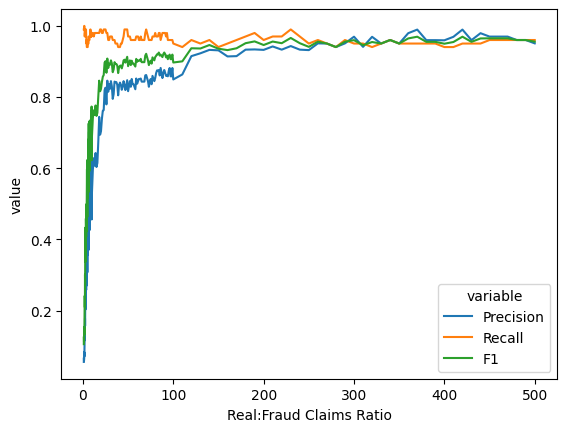

In [138]:
statsDfLong = pd.melt(statsDf, "Real:Fraud Claims Ratio")
plot = sns.lineplot(data=statsDfLong, x='Real:Fraud Claims Ratio', y='value', hue='variable')
plt.show()
#plot.set_xscale('log')

As expected we see that the recall statistic is quite good at lower ratios since the model is tailored to the higher fraction of fraudulent claims, which also makes the precision much worse. I will redo the ratios from 100:1 to maximum again more precisely to getter finer results for this range, since the range from 1:1 to 100:1 doesn't provide good enough statistics anyways.

In [140]:
ratios = []
precision = []
recall = []
f1 = []

# "rat" is part of the ratio between fraud and real claims (fraud:real == 1:rat)
for rat in range(100,578,2):
    print("trying ratio 1:", rat)
    ratios.append(rat)
    # get new X and Y from undersampled dataframe
    fraudFull = df[df["Class"] == 1]
    realSubset = df[df["Class"] == 0].sample(n=int(492*rat), random_state=4)
    dfSubset = pd.concat([fraudFull, realSubset])
    x2 = dfSubset.drop('Class', axis = 'columns').values
    y2 = dfSubset.Class.values
    xTrain2, xTest2, yTrain2, yTest2 = train_test_split(x2, y2, test_size=0.2, random_state=4)
    # train new tree
    rfc2 = RandomForestClassifier(random_state=4, n_jobs=-1)
    rfc2.fit(xTrain2, yTrain2)
    name = "rfcModel" + str(size)
    # test on existing test data
    yPred2 = rfc2.predict(xTest)
    precision.append(precision_score(yTest, yPred2))
    recall.append(recall_score(yTest, yPred2))
    f1.append(f1_score(yTest, yPred2))
        

trying ratio 1: 100
trying ratio 1: 102
trying ratio 1: 104
trying ratio 1: 106
trying ratio 1: 108
trying ratio 1: 110
trying ratio 1: 112
trying ratio 1: 114
trying ratio 1: 116
trying ratio 1: 118
trying ratio 1: 120
trying ratio 1: 122
trying ratio 1: 124
trying ratio 1: 126
trying ratio 1: 128
trying ratio 1: 130
trying ratio 1: 132
trying ratio 1: 134
trying ratio 1: 136
trying ratio 1: 138
trying ratio 1: 140
trying ratio 1: 142
trying ratio 1: 144
trying ratio 1: 146
trying ratio 1: 148
trying ratio 1: 150
trying ratio 1: 152
trying ratio 1: 154
trying ratio 1: 156
trying ratio 1: 158
trying ratio 1: 160
trying ratio 1: 162
trying ratio 1: 164
trying ratio 1: 166
trying ratio 1: 168
trying ratio 1: 170
trying ratio 1: 172
trying ratio 1: 174
trying ratio 1: 176
trying ratio 1: 178
trying ratio 1: 180
trying ratio 1: 182
trying ratio 1: 184
trying ratio 1: 186
trying ratio 1: 188
trying ratio 1: 190
trying ratio 1: 192
trying ratio 1: 194
trying ratio 1: 196
trying ratio 1: 198


In [148]:
statsData = {'Real:Fraud Claims Ratio': ratios,
            'Precision': precision,
            'Recall': recall,
            'F1': f1}
statsDf = pd.DataFrame(data = statsData)
statsDf.to_csv("statsDf.csv", index=False)

In [9]:
statsDf = pd.read_csv("statsDf.csv")

In [10]:
statsDf

,Real:Fraud Claims Ratio,Precision,Recall,F1
0,100,0.858407,0.960396,0.906542
1,102,0.864865,0.950495,0.905660
2,104,0.871560,0.940594,0.904762
3,106,0.855856,0.940594,0.896226
4,108,0.879630,0.940594,0.909091
...,...,...,...,...
234,568,0.980000,0.970297,0.975124
235,570,0.980000,0.970297,0.975124
236,572,0.989899,0.970297,0.980000
237,574,0.980000,0.970297,0.975124


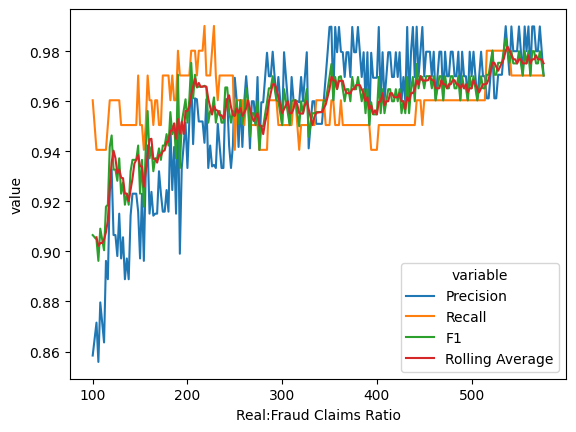

In [11]:
statsDf['Rolling Average'] = statsDf['F1'].rolling(window=3).mean()
statsDfLong = pd.melt(statsDf, "Real:Fraud Claims Ratio")
plot = sns.lineplot(data=statsDfLong, x='Real:Fraud Claims Ratio', y='value', hue='variable')
plt.show()

In [12]:
# where does the rolling average reach its peak
statsDf['Rolling Average'].idxmax()

219

With this more precise graph it seems that recall peaks at around 220, then drops and slowly rises back up when using more of the dataset. Though recall is highest around 220, it isn't very consistent (dropping much lower right after) and the precision isn't all that high either. At a ratio of 538:1, we get a recall and precision score of about 98%. The ratio right before (536:1) gets a slightly higher precision but I'm going with 538:1 since it has a higher rolling average for the F1 score, meaning it is less susceptible to small changes. Let's train this model

In [ ]:
fraudFull = df[df["Class"] == 1]
realSubset = df[df["Class"] == 0].sample(n=int(492*538), random_state=4)
dfSubset = pd.concat([fraudFull, realSubset])
x2 = dfSubset.drop('Class', axis = 'columns').values
y2 = dfSubset.Class.values
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(x2, y2, test_size=0.2, random_state=4)

## Train the model:
rfcUS = RandomForestClassifier(random_state=4)
rfcUS.fit(xTrain2, yTrain2)

# Let's save the model as well
jl.dump(rfcUS, "rfcUndersample.pkl")

In [14]:
# Load the model and do predictions
rfcUS = jl.load("rfcUndersample.pkl")

yPredUS = rfcUS.predict(xTest)

In [15]:
## Showing some statistics
accuracy = accuracy_score(yTest, yPredUS)
precision = precision_score(yTest, yPredUS)
recall = recall_score(yTest, yPredUS)
f1 = f1_score(yTest, yPredUS)
print("Number of Claims:", yTest.shape[0], "\nPercent of Claims that are Valid:", 
      np.where(yTest==0)[0].size / yTest.size, "\nAccuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall, "\nF1 Score:", f1)


Number of Claims: 56962 
Percent of Claims that are Valid: 0.9982268881008391 
Accuracy: 0.9999297777465679 
Precision: 0.9801980198019802 
Recall: 0.9801980198019802 
F1 Score: 0.9801980198019802


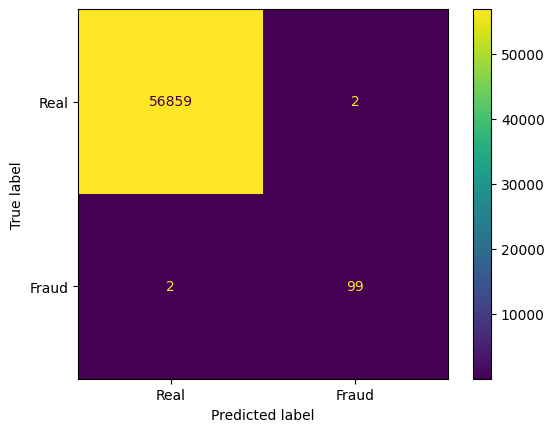

In [16]:
## Plotting a confusion matrix
cm = confusion_matrix(yTest, yPredUS)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Real","Fraud"])
cmd.plot()

We can see that when tested on the same dataset as the original model, it performs much better and makes mistakes much less often (only 4 mislabels). Both recall and precision go up, with recall going from 81.19% to 98.02%, and precision going from 92.13% to 98.02%. Let's just see how both work on the entire dataset.

In [29]:
rfc1pred = rfc.predict(x)
rfcUSpred = rfcUS.predict(x)

In [47]:
Acc1 = accuracy_score(y,rfc1pred)
AccUS = accuracy_score(y,rfcUSpred)
Prec1 = precision_score(y,rfc1pred)
PrecUS = precision_score(y,rfcUSpred)
Rec1 = recall_score(y,rfc1pred)
RecUS = recall_score(y,rfcUSpred)
Fone1 = f1_score(y,rfc1pred)
FoneUS = f1_score(y,rfcUSpred)
compareDF = {
    "Statistic": ["Accuracy","Precision","Recall","F1"],
    "Original Model": [Acc1, Prec1, Rec1, Fone1],
    "Undersampled Model": [AccUS, PrecUS, RecUS, FoneUS]
}

compareDF = pd.DataFrame(data = compareDF)

In [48]:
compareDF

,Statistic,Original Model,Undersampled Model
0,Accuracy,0.999905,0.999916
1,Precision,0.985386,0.991597
2,Recall,0.959350,0.959350
3,F1,0.972194,0.975207


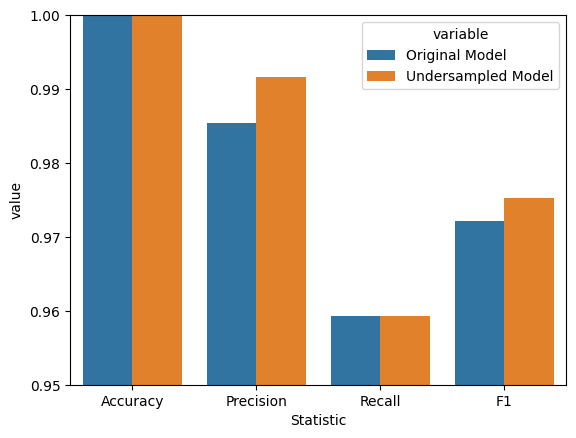

In [55]:
cDFLong = pd.melt(compareDF, "Statistic")
sns.barplot(data=cDFLong, x='Statistic', y='value', hue='variable')
plt.ylim(0.95, 1.0)
plt.show()

From this graph we can see clearly that undersampling has benefitted the model. Unfortunately we have not improved the recall %, but we have increased the precision of our model (despite training it on less data!).